In [ ]:
!pip install dicom2nifti
!pip install monai


In [ ]:
from glob import glob
import shutil
import os
import dicom2nifti
import nibabel as nib
import numpy as np
# from tqdm import tqdm

from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.utils import first
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from matplotlib import pyplot as plt
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference

import torch

In [ ]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128,128,64], cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you 
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
    
    # print(test_files);

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

            
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return [train_loader, test_loader]

In [ ]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.
    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train = data[0];
    check_patient_test = data[1]

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)
    # print(check_patient_train);
    # print(view_train_patient);

    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


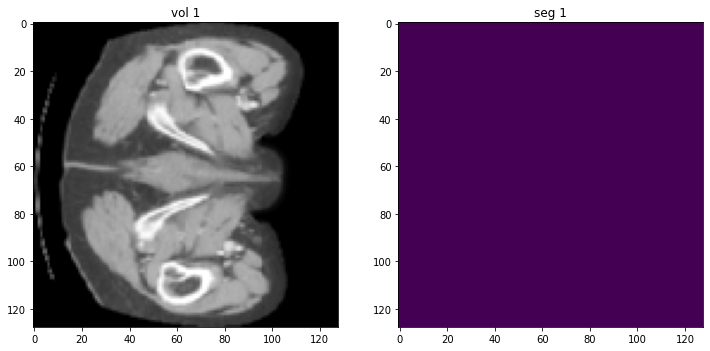

In [ ]:
in_dir = '/content/drive/My Drive/Dataset/Data_Train_Test/'
model_dir = '/content/drive/My Drive/Dataset/results/results'

data_in  = prepare(in_dir)
# data_in
show_patient(data_in)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")

In [ ]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [ ]:

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


In [ ]:
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


In [ ]:
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [ ]:
if __name__ == '__main__':

    train(model, data_in, loss_function, optimizer, 300, model_dir,test_interval=4)

Streaming output truncated to the last 5000 lines.
16/21, Train_loss: 0.2646
Train_dice: 0.7354
17/21, Train_loss: 0.3171
Train_dice: 0.6829
18/21, Train_loss: 0.3461
Train_dice: 0.6539
19/21, Train_loss: 0.4222
Train_dice: 0.5778
20/21, Train_loss: 0.1953
Train_dice: 0.8047
21/21, Train_loss: 0.3750
Train_dice: 0.6250
--------------------
Epoch_loss: 0.3462
Epoch_metric: 0.6538
test_loss_epoch: 0.4172
test_dice_epoch: 0.6525
current epoch: 164 current mean dice: 0.6495
best mean dice: 0.6525 at epoch: 164
----------
epoch 165/300
1/21, Train_loss: 0.3817
Train_dice: 0.6183
2/21, Train_loss: 0.3926
Train_dice: 0.6074
3/21, Train_loss: 0.3982
Train_dice: 0.6018
4/21, Train_loss: 0.4314
Train_dice: 0.5686
5/21, Train_loss: 0.3730
Train_dice: 0.6270
6/21, Train_loss: 0.5466
Train_dice: 0.4534
7/21, Train_loss: 0.2710
Train_dice: 0.7290
8/21, Train_loss: 0.2370
Train_dice: 0.7630
9/21, Train_loss: 0.3435
Train_dice: 0.6565
10/21, Train_loss: 0.4109
Train_dice: 0.5891
11/21, Train_loss: 0.1

In [ ]:
in_dir = '/content/drive/MyDrive/Dataset/Data_Train_Test'
model_dir = '/content/drive/MyDrive/Dataset/results/results'